# Prime numbers factorization embedding

In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns
sns.set(style='ticks', font='DejaVu Sans', palette='tab10')

# NOTE: I AM USING CURRENT MASTER OF OPENTSNE, NOT THE CONDA VERSION (0.4.4)
# IT SHOULD BE RELEASED TO CONDA SOON...

from openTSNE import TSNE, affinity
from umap import UMAP
import warnings

import pickle

In [1]:
import umap, openTSNE, pynndescent
print(umap.__version__)
print(openTSNE.__version__)
print(pynndescent.__version__)

0.4.6
0.4.4
0.5.0


# Generate data
This is copy-pasted from John Williamson's code.

In [19]:
# This code from the excellent module at:
# https://stackoverflow.com/questions/4643647/fast-prime-factorization-module
    
import random

_known_factors = {}    

totients = {}
def primesbelow(N):
    # http://stackoverflow.com/questions/2068372/fastest-way-to-list-all-primes-below-n-in-python/3035188#3035188
    #""" Input N>=6, Returns a list of primes, 2 <= p < N """
    correction = N % 6 > 1
    N = {0:N, 1:N-1, 2:N+4, 3:N+3, 4:N+2, 5:N+1}[N%6]
    sieve = [True] * (N // 3)
    sieve[0] = False
    for i in range(int(N ** .5) // 3 + 1):
        if sieve[i]:
            k = (3 * i + 1) | 1
            sieve[k*k // 3::2*k] = [False] * ((N//6 - (k*k)//6 - 1)//k + 1)
            sieve[(k*k + 4*k - 2*k*(i%2)) // 3::2*k] = [False] * ((N // 6 - (k*k + 4*k - 2*k*(i%2))//6 - 1) // k + 1)
    return [2, 3] + [(3 * i + 1) | 1 for i in range(1, N//3 - correction) if sieve[i]]

smallprimeset = set(primesbelow(1000000))
_smallprimeset = 1000000

smallprimes = primesbelow(10000000) 
prime_ix = {p:i for i,p in enumerate(smallprimes)}

def isprime(n, precision=7):
    # http://en.wikipedia.org/wiki/Miller-Rabin_primality_test#Algorithm_and_running_time
    if n < 1:
        raise ValueError("Out of bounds, first argument must be > 0")
    elif n <= 3:
        return n >= 2
    elif n % 2 == 0:
        return False
    elif n < _smallprimeset:
        return n in smallprimeset


    d = n - 1
    s = 0
    while d % 2 == 0:
        d //= 2
        s += 1

    for repeat in range(precision):
        a = random.randrange(2, n - 2)
        x = pow(a, d, n)

        if x == 1 or x == n - 1: continue

        for r in range(s - 1):
            x = pow(x, 2, n)
            if x == 1: return False
            if x == n - 1: break
        else: return False

    return True

# https://comeoncodeon.wordpress.com/2010/09/18/pollard-rho-brent-integer-factorization/
def pollard_brent(n):
    if n % 2 == 0: return 2
    if n % 3 == 0: return 3

    y, c, m = random.randint(1, n-1), random.randint(1, n-1), random.randint(1, n-1)
    g, r, q = 1, 1, 1
    while g == 1:
        x = y
        for i in range(r):
            y = (pow(y, 2, n) + c) % n

        k = 0
        while k < r and g==1:
            ys = y
            for i in range(min(m, r-k)):
                y = (pow(y, 2, n) + c) % n
                q = q * abs(x-y) % n
            g = gcd(q, n)
            k += m
        r *= 2
    if g == n:
        while True:
            ys = (pow(ys, 2, n) + c) % n
            g = gcd(abs(x - ys), n)
            if g > 1:
                break

    return g

    


def _primefactors(n, sort=False):
    factors = []

    for checker in smallprimes:
        while n % checker == 0:
            factors.append(checker)
            n //= checker
            # early exit memoization
            if n in _known_factors:
                return factors + _known_factors[n]
        if checker > n: break

    if n < 2: return factors

    while n > 1:
        if isprime(n):
            factors.append(n)
            break
        factor = pollard_brent(n) # trial division did not fully factor, switch to pollard-brent
        factors.extend(primefactors(factor)) # recurse to factor the not necessarily prime factor returned by pollard-brent
        n //= factor

    if sort: factors.sort()

    return factors

def primefactors(n, sort=False):
    if n in _known_factors:
        return _known_factors[n]
    
    result = _primefactors(n)
    _known_factors[n] = result
    return result

from collections import defaultdict

def factorization(n):
    factors = defaultdict(int)
    for p1 in primefactors(n):
        factors[p1] += 1        
    return factors

def unique_factorise(n):
    return set(primefactors(n))

def totient(n):
    if n == 0: return 1

    try: return totients[n]
    except KeyError: pass

    tot = 1
    for p, exp in factorization(n).items():
        tot *= (p - 1)  *  p ** (exp - 1)

    totients[n] = tot
    return tot

def gcd(a, b):
    if a == b: return a
    while b > 0: a, b = b, a % b
    return a

def lcm(a, b):
    return abs((a // gcd(a, b)) * b)



### end



## Create sparse binary factor vectors for any number, and assemble into a matrix
## One column for each unique prime factor
## One row for each number, 0=does not have this factor, 1=does have this factor (might be repeated)

from scipy.special import expi
import scipy.sparse

def factor_vector_lil(n):
    ## approximate prime counting function (upper bound for the values we are interested in)
    ## gives us the number of rows (dimension of our space)
    d = int(np.ceil(expi(np.log(n))))    
    x = scipy.sparse.lil_matrix((n,d))
    for i in range(2,n):                                          
        for k,v in factorization(i).items():            
            x[i,prime_ix[k]] = 1
                    
        if i%100000==0: # just check it is still alive...
            print(i)        
    return x

In [20]:
### Generate the matrix for 100k integers

n = 100000
%time X = factor_vector_lil(n) 
pickle.dump(X, open('prime-factors/pickles/X-100k.pickle', 'wb'))

### Generate the matrix for 1 million integers

n = 1000000
%time X = factor_vector_lil(n) 
pickle.dump(X, open('prime-factors/pickles/X-1mln.pickle', 'wb'))

CPU times: user 5.86 s, sys: 32 ms, total: 5.89 s
Wall time: 5.89 s
100000
200000
300000
400000
500000
600000
700000
800000
900000
CPU times: user 3min 26s, sys: 816 ms, total: 3min 26s
Wall time: 3min 26s


In [3]:
# Check sparsity

X = pickle.load(open('prime-factors/pickles/X-1mln.pickle', 'rb'))
np.sum(X) / np.prod(X.shape) * 100

0.0036293763036068572

# OLD VERSION OF UMAP (I ran this in February 2020)

In [64]:
%%time

with warnings.catch_warnings():        # Unfortunately still lots of Numba parallel warnings
    warnings.simplefilter('ignore')
    Z1mln = UMAP(metric='cosine', n_epochs=500).fit_transform(X)

CPU times: user 4h 15min 33s, sys: 9min 42s, total: 4h 25min 15s
Wall time: 2h 48min 51s


In [145]:
# DO NOT OVERWRITE THIS PICKLE ANYMORE!

pickle.dump([Z100k, Z1mln], open('prime-factors/pickles/umap-results.pickle', 'wb'))

# Run t-SNE and UMAP

In [11]:
# Desktop runtimes

X = pickle.load(open('prime-factors/pickles/X-100k.pickle', 'rb'))

%time Z = UMAP(metric='cosine').fit_transform(X)

pickle.dump(Z, open('prime-factors/pickles/umap-100k.pickle', 'wb'))

%time A = affinity.Uniform(X, k_neighbors=15, metric='cosine', n_jobs=-1)
%time Z = TSNE(affinities=A, n_jobs=-1, initialization='random', random_state=42).fit(X)

pickle.dump(np.array(Z), open('prime-factors/pickles/tsne-100k.pickle', 'wb'))

CPU times: user 8min 15s, sys: 24.8 s, total: 8min 39s
Wall time: 1min 23s
CPU times: user 3min 38s, sys: 288 ms, total: 3min 38s
Wall time: 33 s
CPU times: user 6min 43s, sys: 6.15 s, total: 6min 49s
Wall time: 52.8 s


In [12]:
# Desktop runtimes (UMAP needs 19 Gb RAM)

X = pickle.load(open('prime-factors/pickles/X-1mln.pickle', 'rb'))

%time Z = UMAP(metric='cosine').fit_transform(X)

pickle.dump(Z, open('prime-factors/pickles/umap-1mln.pickle', 'wb'))

%time A = affinity.Uniform(X, k_neighbors=15, metric='cosine', n_jobs=-1)
%time Z = TSNE(affinities=A, n_jobs=-1, initialization='random', random_state=42).fit(X)

pickle.dump(np.array(Z), open('prime-factors/pickles/tsne-1mln.pickle', 'wb'))

CPU times: user 3h 35min 37s, sys: 8min 8s, total: 3h 43min 46s
Wall time: 32min 1s
CPU times: user 1h 14min 10s, sys: 4.61 s, total: 1h 14min 14s
Wall time: 10min 1s
CPU times: user 46min 28s, sys: 34.7 s, total: 47min 3s
Wall time: 7min


In [13]:
# Desktop (32 Gb RAM). Using pynndescent 0.5, UMAP 0.4.6, openTSNE 0.4.4.

%time Z1 = UMAP(metric='cosine').fit_transform(X)

%time A  = affinity.Uniform(X, k_neighbors=15, metric='cosine', n_jobs=-1)
%time Z2 = TSNE(affinities=A, initialization='random', random_state=42, n_jobs=-1).fit(X)

(1000000, 78628) 

0.4.6
0.5.0
0.4.4 

CPU times: user 3h 35min 7s, sys: 8min 12s, total: 3h 43min 20s
Wall time: 32min 4s
CPU times: user 1h 14min 46s, sys: 4.13 s, total: 1h 14min 50s
Wall time: 10min 5s
CPU times: user 48min 4s, sys: 46 s, total: 48min 50s
Wall time: 7min 24s


In [4]:
# Laptop (16 Gb RAM; UMAP runs out of memory and crashes)

%time A  = affinity.Uniform(X, k_neighbors=15, metric='cosine', n_jobs=-1)
%time Z2 = TSNE(affinities=A, initialization='random', random_state=42, n_jobs=-1).fit(X)

CPU times: user 1h 37min 8s, sys: 16.7 s, total: 1h 37min 25s
Wall time: 14min 13s
CPU times: user 57min 45s, sys: 52.3 s, total: 58min 37s
Wall time: 10min 23s


# Make figures

In [17]:
def myscatter(X,Z, s=1, until=8, labels=True):
    for i in range(1,until):
        ind = np.array(np.sum(X,axis=1) == i).squeeze()
        if np.sum(ind)>0:
            plt.scatter(Z[ind,0], Z[ind,1], s=s, edgecolors='none', label=i)
    
    if not labels:
        return
    
    primes = [2,3,5,7,11,13,17,19]
    
    for i in range(8):
        ind = ((X[:,i]==1).toarray()).flatten() &  np.array((np.sum(X,axis=1) == 2)).flatten()
        plt.text(np.median(Z[ind,0]), np.median(Z[ind,1]), f'{primes[i]}', fontsize=10, ha='center', va='center')

    for i in range(5):
        for j in range(5):
            if i>=j:
                continue
            ind = ((X[:,i]==1).toarray() & (X[:,j]==1).toarray()).flatten() & np.array((np.sum(X,axis=1) == 3)).flatten()
            plt.text(np.median(Z[ind,0]), np.median(Z[ind,1]), f'{primes[i]},{primes[j]}', 
                     fontsize=10, ha='center', va='center')

## 100k dataset

In [18]:
X = pickle.load(open('prime-factors/pickles/X-100k.pickle', 'rb'))
Zu = pickle.load(open('prime-factors/pickles/umap-100k.pickle', 'rb'))
Zt = pickle.load(open('prime-factors/pickles/tsne-100k.pickle', 'rb'))
Zo, _ = pickle.load(open('prime-factors/pickles/umap-results.pickle', 'rb'))

<IPython.core.display.Javascript object>


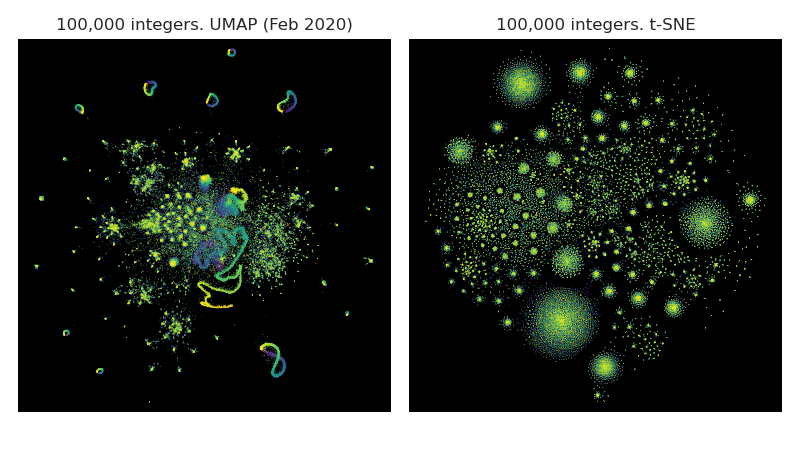

In [4]:
fig = plt.figure(figsize=(8,4.5))

ax = plt.subplot(121)
ax.set_box_aspect(1)
ax.set_aspect('equal', adjustable='datalim')
ax.set_facecolor('black')
plt.set_cmap('viridis')
plt.scatter(Zo[:,0], Zo[:,1], s=.3, edgecolors='none', c=np.arange(X.shape[0]))
plt.xticks([])
plt.yticks([])
plt.title('100,000 integers. UMAP (Feb 2020)')

ax = plt.subplot(122)
ax.set_box_aspect(1)
ax.set_aspect('equal', adjustable='datalim')
ax.set_facecolor('black')
plt.set_cmap('viridis')
plt.scatter(Zt[:,0], Zt[:,1], s=.3, edgecolors='none', c=np.arange(X.shape[0]))
plt.xticks([])
plt.yticks([])
plt.title('100,000 integers. t-SNE')

sns.despine(left=True, bottom=True)
plt.tight_layout()

<IPython.core.display.Javascript object>


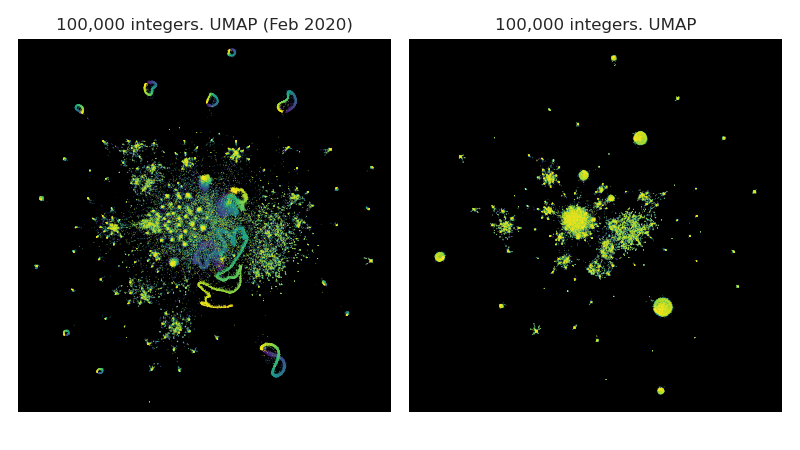

In [9]:
fig = plt.figure(figsize=(8,4.5))

ax = plt.subplot(121)
ax.set_box_aspect(1)
ax.set_aspect('equal', adjustable='datalim')
ax.set_facecolor('black')
plt.set_cmap('viridis')
plt.scatter(Zo[:,0], Zo[:,1], s=.3, edgecolors='none', c=np.arange(X.shape[0]))
plt.xticks([])
plt.yticks([])
plt.title('100,000 integers. UMAP (Feb 2020)')

ax = plt.subplot(122)
ax.set_box_aspect(1)
ax.set_aspect('equal', adjustable='datalim')
ax.set_facecolor('black')
plt.set_cmap('viridis')
plt.scatter(Zu[:,0], Zu[:,1], s=.3, edgecolors='none', c=np.arange(X.shape[0]))
plt.xticks([])
plt.yticks([])
plt.title('100,000 integers. UMAP')

sns.despine(left=True, bottom=True)
plt.tight_layout()

<IPython.core.display.Javascript object>


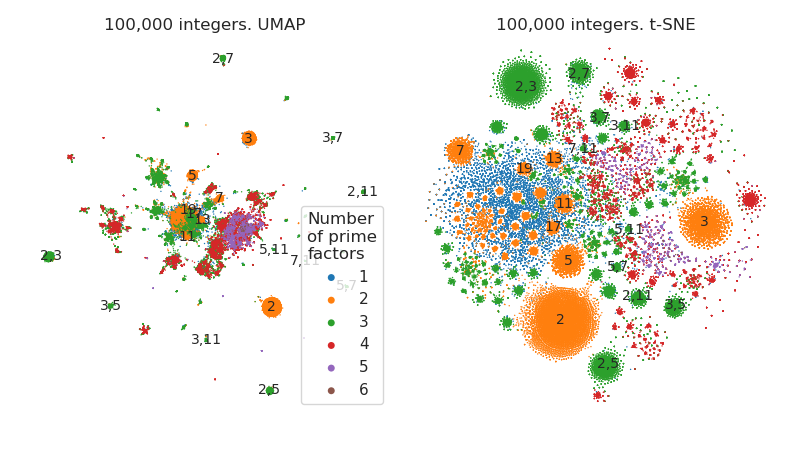

In [19]:
fig = plt.figure(figsize=(8,4.5))

ax = plt.subplot(121)
ax.set_box_aspect(1)
ax.set_aspect('equal', adjustable='datalim')
myscatter(X,Zu)
plt.xticks([])
plt.yticks([])
plt.legend(markerscale=5, title='Number\nof prime\nfactors', loc='lower right')
plt.title('100,000 integers. UMAP')

ax = plt.subplot(122)
ax.set_box_aspect(1)
ax.set_aspect('equal', adjustable='datalim')
myscatter(X,Zt)
plt.xticks([])
plt.yticks([])
plt.title('100,000 integers. t-SNE')

sns.despine(left=True, bottom=True)
plt.tight_layout()

## 1mln dataset

In [2]:
X = pickle.load(open('prime-factors/pickles/X-1mln.pickle', 'rb'))
Zu = pickle.load(open('prime-factors/pickles/umap-1mln.pickle', 'rb'))
Zt = pickle.load(open('prime-factors/pickles/tsne-1mln.pickle', 'rb'))
_, Zo = pickle.load(open('prime-factors/pickles/umap-results.pickle', 'rb'))

<IPython.core.display.Javascript object>


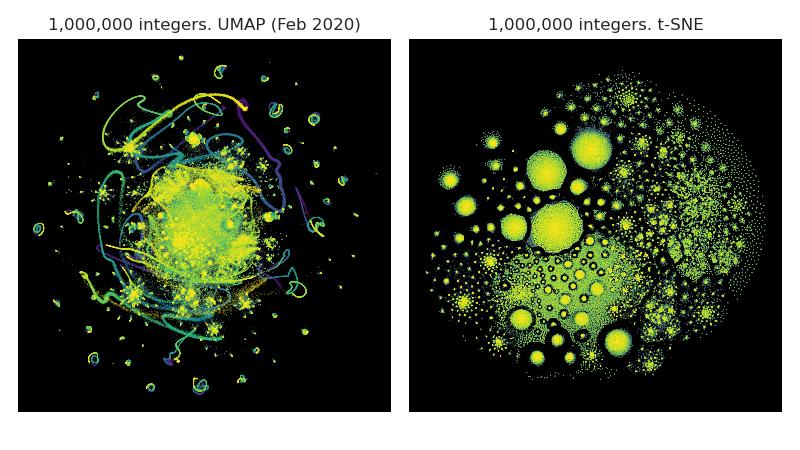

In [12]:
fig = plt.figure(figsize=(8,4.5))

ax = plt.subplot(121)
ax.set_box_aspect(1)
ax.set_aspect('equal', adjustable='datalim')
ax.set_facecolor('black')
plt.set_cmap('viridis')
plt.scatter(Zo[:,0], Zo[:,1], s=.2, edgecolors='none', c=np.arange(X.shape[0]))
plt.xticks([])
plt.yticks([])
plt.title('1,000,000 integers. UMAP (Feb 2020)')

ax = plt.subplot(122)
ax.set_box_aspect(1)
ax.set_aspect('equal', adjustable='datalim')
ax.set_facecolor('black')
plt.set_cmap('viridis')
plt.scatter(Zt[:,0], Zt[:,1], s=.2, edgecolors='none', c=np.arange(X.shape[0]))
plt.xticks([])
plt.yticks([])
plt.title('1,000,000 integers. t-SNE')

sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.savefig('prime-factors/1mln-umapold-tsne.png', dpi=200)

<IPython.core.display.Javascript object>


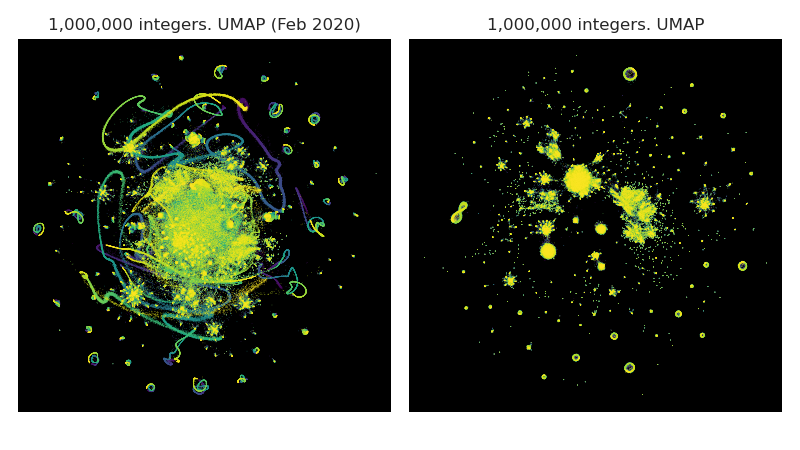

In [13]:
fig = plt.figure(figsize=(8,4.5))

ax = plt.subplot(121)
ax.set_box_aspect(1)
ax.set_aspect('equal', adjustable='datalim')
ax.set_facecolor('black')
plt.set_cmap('viridis')
plt.scatter(Zo[:,0], Zo[:,1], s=.2, edgecolors='none', c=np.arange(X.shape[0]))
plt.xticks([])
plt.yticks([])
plt.title('1,000,000 integers. UMAP (Feb 2020)')

ax = plt.subplot(122)
ax.set_box_aspect(1)
ax.set_aspect('equal', adjustable='datalim')
ax.set_facecolor('black')
plt.set_cmap('viridis')
plt.scatter(Zu[:,0], Zu[:,1], s=.2, edgecolors='none', c=np.arange(X.shape[0]))
plt.xticks([])
plt.yticks([])
plt.title('1,000,000 integers. UMAP')

sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.savefig('prime-factors/1mln-umapold-umap.png', dpi=200)

<IPython.core.display.Javascript object>


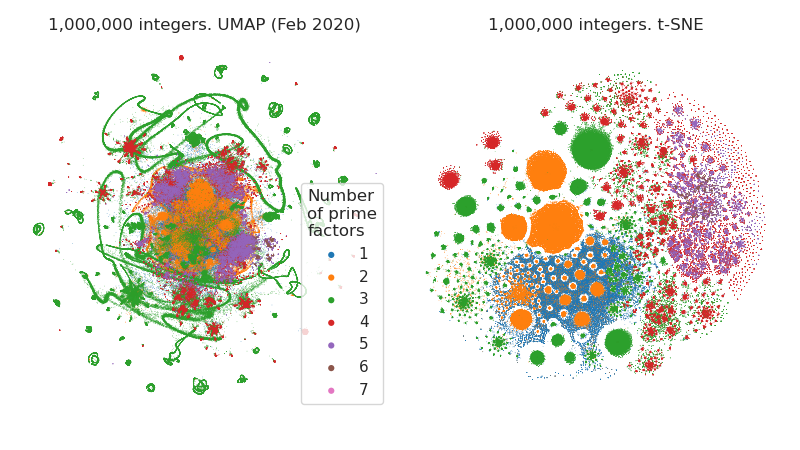

In [14]:
fig = plt.figure(figsize=(8,4.5))

ax = plt.subplot(121)
ax.set_box_aspect(1)
ax.set_aspect('equal', adjustable='datalim')
myscatter(X, Zo, s=.2, labels=False)
plt.xticks([])
plt.yticks([])
plt.legend(markerscale=10, title='Number\nof prime\nfactors', loc='lower right')
plt.title('1,000,000 integers. UMAP (Feb 2020)')

ax = plt.subplot(122)
ax.set_box_aspect(1)
ax.set_aspect('equal', adjustable='datalim')
myscatter(X, Zt, s=.2, labels=False)
plt.xticks([])
plt.yticks([])
plt.title('1,000,000 integers. t-SNE')

sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.savefig('prime-factors/1mln-umapold-tsne-colored.png', dpi=200)

<IPython.core.display.Javascript object>


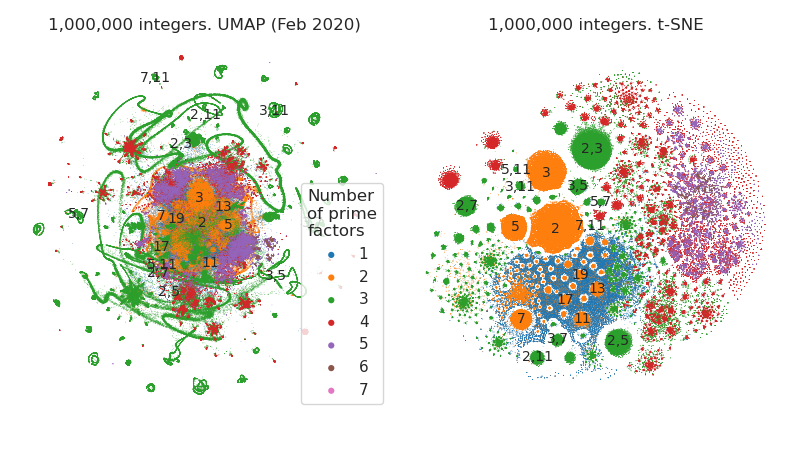

In [21]:
fig = plt.figure(figsize=(8,4.5))

ax = plt.subplot(121)
ax.set_box_aspect(1)
ax.set_aspect('equal', adjustable='datalim')
myscatter(X, Zo, s=.2)
plt.xticks([])
plt.yticks([])
plt.legend(markerscale=10, title='Number\nof prime\nfactors', loc='lower right')
plt.title('1,000,000 integers. UMAP (Feb 2020)')

ax = plt.subplot(122)
ax.set_box_aspect(1)
ax.set_aspect('equal', adjustable='datalim')
myscatter(X, Zt, s=.2)
plt.xticks([])
plt.yticks([])
plt.title('1,000,000 integers. t-SNE')

sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.savefig('prime-factors/1mln-umapold-tsne-explainer.png', dpi=200)

<IPython.core.display.Javascript object>


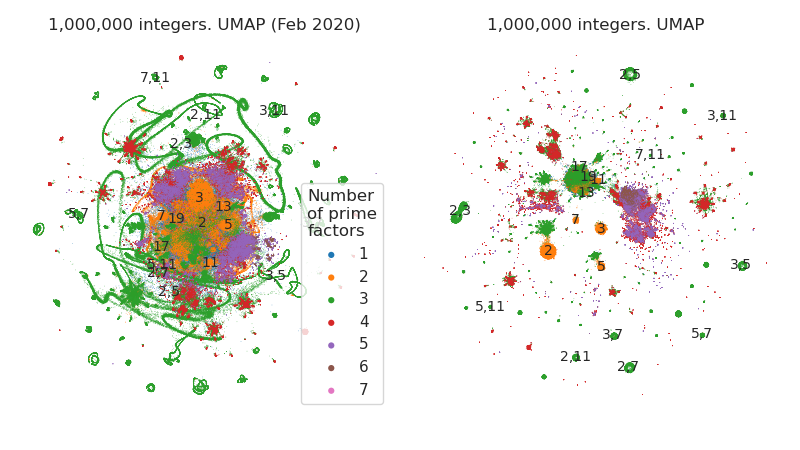

In [22]:
fig = plt.figure(figsize=(8,4.5))

ax = plt.subplot(121)
ax.set_box_aspect(1)
ax.set_aspect('equal', adjustable='datalim')
myscatter(X, Zo, s=.2)
plt.xticks([])
plt.yticks([])
plt.legend(markerscale=10, title='Number\nof prime\nfactors', loc='lower right')
plt.title('1,000,000 integers. UMAP (Feb 2020)')

ax = plt.subplot(122)
ax.set_box_aspect(1)
ax.set_aspect('equal', adjustable='datalim')
myscatter(X, Zu, s=.2)
plt.xticks([])
plt.yticks([])
plt.title('1,000,000 integers. UMAP')

sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.savefig('prime-factors/1mln-umapold-umap-explainer.png', dpi=200)

In [52]:
print(np.array(X[:20,:36].todense()).astype(int), '\n\n', X.shape)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0

<IPython.core.display.Javascript object>


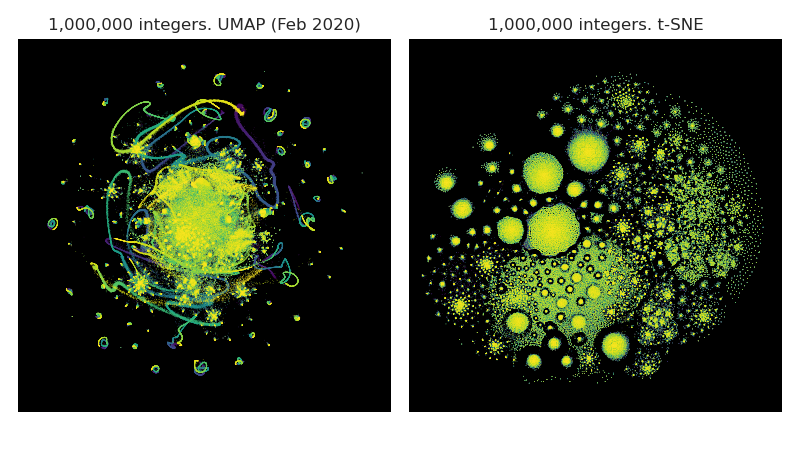

In [24]:
fig = plt.figure(figsize=(8,4.5))

ax1 = plt.subplot(121)
ax1.set_box_aspect(1)
ax1.set_aspect('equal', adjustable='datalim')
ax1.set_facecolor('black')
plt.set_cmap('viridis')
plt.xticks([])
plt.yticks([])
plt.title('1,000,000 integers. UMAP (Feb 2020)')
plt.xlim([np.min(Zo[:,0])*1.2, np.max(Zo[:,0])*1.2])
plt.ylim([np.min(Zo[:,1])*1.2, np.max(Zo[:,1])*1.2])

ax2 = plt.subplot(122)
ax2.set_box_aspect(1)
ax2.set_aspect('equal', adjustable='datalim')
ax2.set_facecolor('black')
plt.set_cmap('viridis')
plt.xticks([])
plt.yticks([])
plt.title('1,000,000 integers. t-SNE')
plt.xlim([np.min(Zt[:,0])*1.2, np.max(Zt[:,0])*1.2])
plt.ylim([np.min(Zt[:,1])*1.2, np.max(Zt[:,1])*1.2])

sns.despine(left=True, bottom=True)
plt.tight_layout()
    
for step in range(50):
    ax1.scatter(Zo[20000*step:20000*(step+1),0], Zo[20000*step:20000*(step+1),1], s=.2, 
                edgecolors='none', c=np.arange(X.shape[0])[20000*step:20000*(step+1)], 
                vmin=0, vmax=1e+6)
    
    ax2.scatter(Zt[20000*step:20000*(step+1),0], Zt[20000*step:20000*(step+1),1], s=.2, 
                edgecolors='none', c=np.arange(X.shape[0])[20000*step:20000*(step+1)],
                vmin=0, vmax=1e+6)

    plt.savefig(f'prime-factors/animation-{step:02d}.png', dpi=100)
    
import subprocess, os
subprocess.call(["convert", "-delay", "10", "-loop", "0", 
                 "prime-factors/animation-*.png", "prime-factors/animation.gif"])
for step in range(50):
    os.remove(f'prime-factors/animation-{step:02d}.png')